In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
from array import array
import ctypes
import h5py

Welcome to JupyROOT 6.28/06


In [2]:
!ls /eos/user/j/jlai/tau_test

bdt_training_latest.py	ditau_flattened_2.h5  graviton_flattened_M1000.h5
bdt_training.py		ditau_flattened_3.h5  graviton_flattened_M1750.h5
combined_data.csv	ditau_flattened_4.h5  graviton_flattened_M2000.h5
combined_data.h5	ditau_flattened_5.h5  graviton_flattened_M2500.h5
conda_env.txt		ditau_flattened_6.h5  graviton_flattened_M5000.h5
ditau_flattened_0.h5	ditau_flattened_7.h5  plotter_v4.py
ditau_flattened_10.h5	ditau_flattened_8.h5  skimmer.py
ditau_flattened_11.h5	ditau_flattened_9.h5  test.py
ditau_flattened_12.h5	ditau_no_empty.py
ditau_flattened_1.h5	gamma_flattened_0.h5


In [3]:
def getXS(dsid):
    xs_file = "/cvmfs/atlas.cern.ch/repo/sw/database/GroupData/dev/PMGTools/PMGxsecDB_mc16.txt"
    try:
        with open(xs_file, "r") as f:
            for line in f:
                columns = line.split()
                if columns[0] == str(dsid):
                    return float(columns[2])*float(columns[3])*float(columns[4])
        print( "Couldn't find cross section for dsid", dsid, "so setting to 1.")
    except IOError:
        print("Cross section file not accessible on cvmfs.", dsid, " XS setting to 1.")
    return 1

def flattened_pt_weighted(data, bins, weight):
    weights = np.zeros(len(data))
    pt_hist, bin_edges = np.histogram(data, bins=bins, weights=weight)
    for i in range(len(pt_hist)):
        if pt_hist[i] == 0:
            weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1, weights)
        else:
            weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1/pt_hist[i], weights)

    return weights

path = '/eos/user/j/jlai/tau_test/'

dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score"]

index = 0
ditau = h5py.File(path+f"ditau_flattened_{index}.h5")
ditau.keys()

<KeysViewHDF5 ['IsTruthHadronic', 'R_isotrack', 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'bdt_score', 'd0_leadtrack_lead', 'd0_leadtrack_subl', 'ditau_pt', 'event_id', 'event_weight', 'f_core_lead', 'f_core_subl', 'f_isotracks', 'f_subjet_subl', 'f_subjets', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl', 'n_subjets', 'n_track', 'n_tracks_lead', 'n_tracks_subl']>

In [21]:
# H5 -> Panda DataFrame
# Cross Section
bkg_xs = [364700, 364701, 364702, 364703, 364704, 364705, 364706,
      364707, 364708, 364709, 364710, 364711, 364712]
graviton_xs = [425108, 425101, 425102, 425104, 425107]
gamma_xs = [425200]

# File Location
bkg_filelist = []
for index in tqdm(range(13)):
    bkg_filelist.append(f"ditau_flattened_{index}.h5")
    
graviton_filelist = ["graviton_flattened_M1000.h5",
                    "graviton_flattened_M1750.h5",
                    "graviton_flattened_M2000.h5",
                    "graviton_flattened_M2500.h5",
                    "graviton_flattened_M5000.h5"]
gamma_filelist = ["gamma_flattened_0.h5"]

# Selection Cut
def bkg_cut(df_chunk):
    return ((df_chunk['n_subjets'] >=2) &
           (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
           (((df_chunk['n_tracks_lead'] == 1) & (df_chunk['n_tracks_subl'] == 3)) |
            ((df_chunk['n_tracks_lead'] == 3) & (df_chunk['n_tracks_subl'] == 1))))

def signal_cut(df_chunk):
    return ((df_chunk['IsTruthHadronic']==1) & (df_chunk['n_subjets'] >=2) &
              (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
              (((df_chunk['n_tracks_lead'] == 1) & (df_chunk['n_tracks_subl'] == 3)) |
               ((df_chunk['n_tracks_lead'] == 3) & (df_chunk['n_tracks_subl'] == 1))))

# Define the chunk size
chunk_size = 10000000  # Adjust this size to suit your system's memory

# Define pT bins for pt weight
pt_bins = np.linspace(200000, 1000000, 41)

def h52panda(filelist, xs, cut):
    combined = pd.DataFrame()
    
    for index in range(len(filelist)):
        file_path = path + filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')

            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                # Apply Cut
                filtered_chunk = df_chunk[cut(df_chunk)]
                filtered_chunk = filtered_chunk.copy()
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index])

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])

    return combined


100%|██████████| 13/13 [00:00<00:00, 57516.83it/s]


In [23]:
combined_gamma = h52panda(gamma_filelist, gamma_xs, signal_cut)

gamma_flattened_0.h5: 1507224


In [24]:
combined_graviton = h52panda(graviton_filelist, graviton_xs, signal_cut)

graviton_flattened_M1000.h5: 217986
graviton_flattened_M1750.h5: 319758
graviton_flattened_M2000.h5: 340018
graviton_flattened_M2500.h5: 359283
graviton_flattened_M5000.h5: 114803


In [22]:
combined_bkg = h52panda(bkg_filelist, bkg_xs, bkg_cut)

ditau_flattened_0.h5: 2464
ditau_flattened_1.h5: 3963
ditau_flattened_2.h5: 90828
ditau_flattened_3.h5: 101086942
ditau_flattened_4.h5: 285968626
ditau_flattened_5.h5: 137656105
ditau_flattened_6.h5: 21222249
ditau_flattened_7.h5: 9343864
ditau_flattened_8.h5: 10599522
ditau_flattened_9.h5: 4983206
ditau_flattened_10.h5: 1372916
ditau_flattened_11.h5: 368159
ditau_flattened_12.h5: 1328866


In [26]:
combined_gamma['event_weight']

0      2.144722e-10
1      2.144722e-10
2      2.144722e-10
3      2.144722e-10
4      2.144722e-10
           ...     
591    2.144722e-10
592    2.144722e-10
593    2.144722e-10
594    2.144722e-10
595    2.144722e-10
Name: event_weight, Length: 596, dtype: float32

In [25]:
combined_signal = pd.concat([combined_graviton, combined_gamma])
combined_signal['label'] = 1
combined_bkg['label'] = 0
df = pd.concat([combined_bkg, combined_signal])
df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,d0_leadtrack_lead,d0_leadtrack_subl,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,pT_weight,label
count,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,...,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06,1.250008e+06
mean,2.073469e+08,4.314821e+05,8.599625e-02,8.598232e-01,4.343382e-01,6.459963e-02,8.185765e-01,1.535393e-02,8.801538e-02,1.161827e-01,...,1.314566e-04,-2.685047e-04,4.818622e+00,2.784576e+00,1.215424e+00,2.453791e+00,1.323679e-02,5.061146e-01,1.463629e+05,8.598905e-02
std,1.541140e+08,1.848540e+05,2.803586e-01,8.018176e-02,9.299924e-01,7.808372e-02,9.088418e-02,5.143357e-02,6.308152e-02,5.708309e-02,...,9.080894e-02,8.296435e-02,1.882576e+00,6.200332e-01,6.200332e-01,8.112362e-01,7.177865e+00,1.070053e-01,1.595552e+07,2.803480e-01
min,1.100000e+01,2.000000e+05,0.000000e+00,7.191471e-03,-9.990000e+02,2.818542e-03,9.065603e-02,0.000000e+00,1.995845e-05,5.141489e-05,...,-1.015450e+00,-1.015759e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.141540e-16,2.653651e-01,1.223512e-04,0.000000e+00
25%,7.486453e+07,2.835498e+05,0.000000e+00,8.237001e-01,2.080576e-01,2.565942e-02,7.623755e-01,4.393913e-03,2.783665e-02,7.045903e-02,...,-1.268519e-02,0.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,5.266469e-06,4.261235e-01,1.503699e-02,0.000000e+00
50%,1.899996e+08,3.872953e+05,0.000000e+00,8.742300e-01,4.272144e-01,3.605864e-02,8.344134e-01,1.042417e-02,7.588322e-02,1.230885e-01,...,0.000000e+00,0.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,2.586745e-05,4.895090e-01,3.608175e-01,0.000000e+00
75%,2.939786e+08,5.260121e+05,0.000000e+00,9.139875e-01,6.306282e-01,5.891501e-02,8.880823e-01,1.992010e-02,1.476208e-01,1.665299e-01,...,1.265582e-02,0.000000e+00,5.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.414484e-04,5.648351e-01,5.069307e+00,0.000000e+00
max,4.930031e+08,9.999968e+05,1.000000e+00,9.975535e-01,1.000000e+00,5.146357e-01,1.067907e+00,3.191106e+01,2.000000e-01,1.999999e-01,...,1.015996e+00,1.017063e+00,4.800000e+01,3.000000e+00,3.000000e+00,1.600000e+01,4.011992e+03,8.212081e-01,4.662652e+09,1.000000e+00


In [15]:
''' save the dataframe
df.to_csv('/eos/user/j/jlai/tau_test/combined_data.csv', index=False)
df = pd.read_csv('/eos/user/j/jlai/tau_test/combined_data.csv')
df
'''

In [41]:
combined_signal = pd.concat([combined_graviton, combined_gamma])
combined_signal['label'] = 1
combined_bkg['label'] = 0
df = pd.concat([combined_bkg, combined_signal])

training_vars = ["f_core_lead", 
                "f_core_subl", 
                "f_subjet_subl", 
                "f_subjets", 
                "f_isotracks", 
                "R_max_lead",
                "R_max_subl", 
                "R_isotrack", 
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl", 
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl", 
                "n_track", 
                "n_tracks_lead"]


# Scrambling 
# Calculate the modulo of each eventID with 5
df['eventID_mod'] = df['event_id'] % 5

df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

# df[log_vars] = np.log(df[log_vars])
# df = df[~df[log_vars].isin([np.inf, -np.inf]).any(axis=1)]
# df[abs_log_var] = np.log(np.abs(df[abs_log_var]))
# df = df[~df[abs_log_var].isin([np.inf, -np.inf]).any(axis=1)]

train_df = df[df['eventID_mod'] < 4] # 80%
test_df = df[df['eventID_mod'] == 4] # 20%

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

#Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
testing_data.rename(columns=feature_mapping, inplace=True)

print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)

training data:  (999842, 17)
training labels:  (999842,)
training weights:  (999842,)
testing data:  (250166, 17)
testing labels:  (250166,)
testing weights:  (250166,)


/tmp/ipykernel_462/3529417232.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_462/3529417232.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


In [42]:
from xgboost import XGBClassifier

# create the BDT
params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)

# Train the classifier
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

[23:54:15] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-logloss:0.63551
[23:54:16] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-logloss:0.59342
[23:54:16] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-logloss:0.55802
[23:54:17] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-logloss:0.52189
[23:54:17] INFO: /build/jenkins/workspace/lcg_releas

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

/tmp/ipykernel_462/1924533157.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)


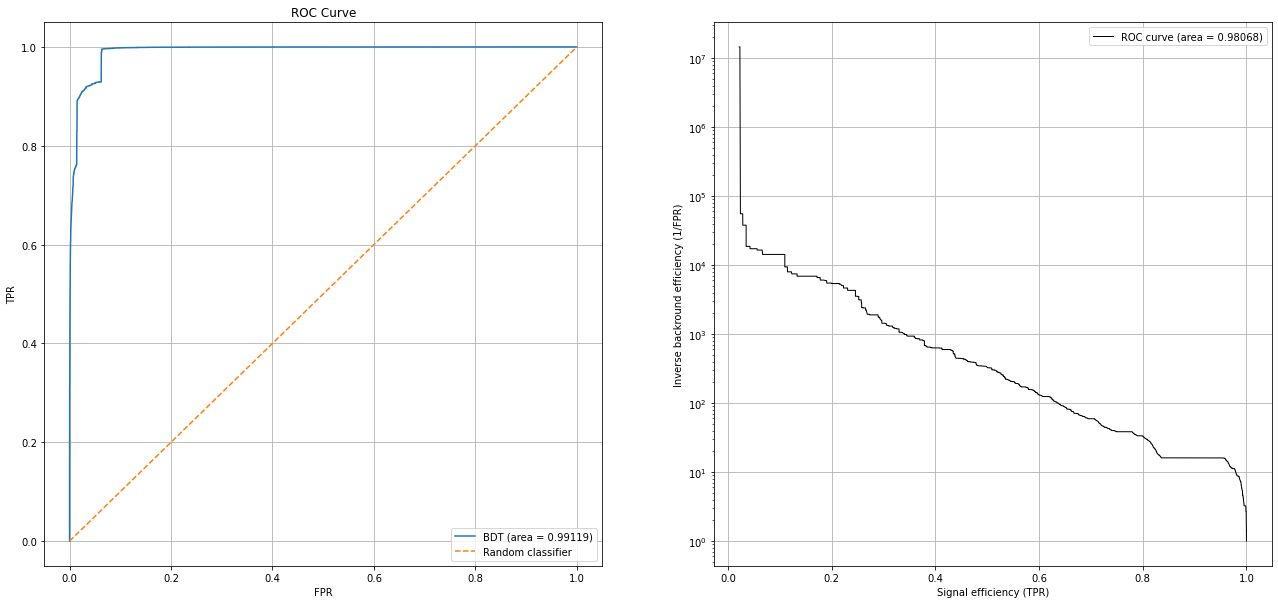

In [43]:
# Predict probabilities for the testing data
probs = bdt.predict_proba(testing_data)
probs = probs[:, 1]

fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_w, tpr_w, label='BDT (area = {:.5f})'.format(auc_w))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Old Code
combined_data = df.sample(frac=1, random_state=42).reset_index(drop=True)

pd_data = combined_data[training_vars]
pd_weights = combined_data["weight"]
pd_labels = combined_data["label"]

feature_mapping = {feature: i for i, feature in enumerate(pd_data.columns)}
pd_data.rename(columns=feature_mapping, inplace=True)

# split the data into training and testing sets
training_data = pd_data[:int(len(pd_data)*0.8)]
training_labels = pd_labels[:int(len(pd_labels)*0.8)]
training_weights = pd_weights[:int(len(pd_weights)*0.8)]
print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)

testing_data = pd_data[int(len(pd_data)*0.8):]
testing_labels = pd_labels[int(len(pd_labels)*0.8):]
testing_weights = pd_weights[int(len(pd_weights)*0.8):]
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)

from xgboost import XGBClassifier

# create the BDT

params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)
print(type(bdt))

# Train the classifier
# bdt.fit(training_data, training_labels, sample_weight=training_weights)
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

/tmp/ipykernel_462/4224524376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data.rename(columns=feature_mapping, inplace=True)


training data:  (403712, 17)
training labels:  (403712,)
training weights:  (403712,)
testing data:  (100928, 17)
testing labels:  (100928,)
testing weights:  (100928,)
<class 'xgboost.sklearn.XGBClassifier'>
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-logloss:0.66358
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-logloss:0.63561
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-logloss:0.61217
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

/tmp/ipykernel_462/1924533157.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)


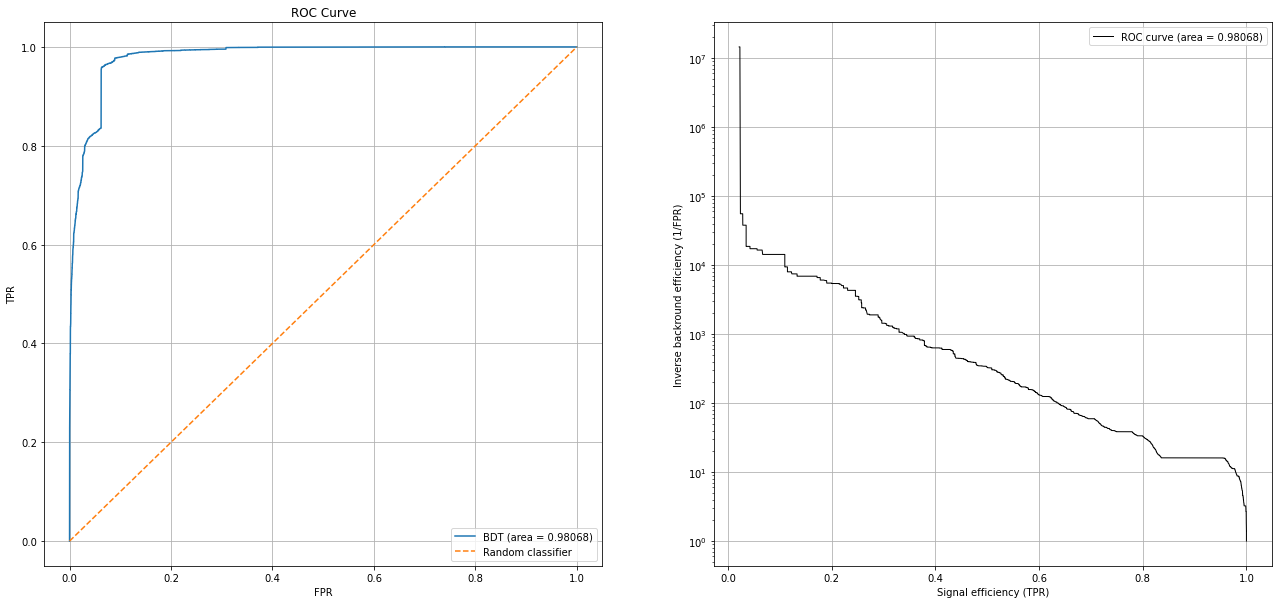

In [37]:
# Predict probabilities for the testing data
probs = bdt.predict_proba(testing_data)
probs = probs[:, 1]

fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_w, tpr_w, label='BDT (area = {:.5f})'.format(auc_w))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()